In [1]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

from pydub import AudioSegment
from td_utils import *

/home/pablo/environments/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.regularizers import L1L2

Using TensorFlow backend.


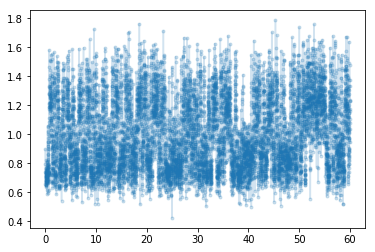

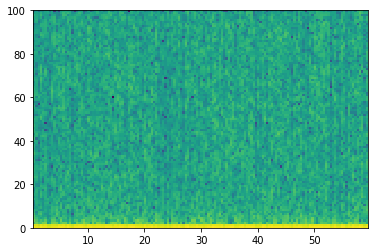

In [3]:
i = randint(0,4000)
Ft = load("syndat/d"+str(i).zfill(4)+".npy")
t = arange(len(Ft))*5e-3
figure()
plot(t,Ft,'.-',alpha=0.2)
figure()
x = graph_spectrogram("syndat/d0000.npy")

In [4]:
Tx = len(Ft)
nfreq = 101

In [5]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [6]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [7]:
pars = load("syndat/pars.npy")
print(len(pars),pars[0])

4200 [1.52550541 2.48263258 4.59159414 1.        ]


In [8]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 2000 


X = []
Y = []
for i in range(4000):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        start,end = get_random_time_segment(nframes)
        X.append(xt[start:end])
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(clip(yt[start:end].flatten()+(par[-1]>1),0,1))
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(clip(yt[start:end].flatten()+(par[-1]>1),0,1))
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(20000, 2000) (20000, 2000)
(500, 2000) (500, 2000)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

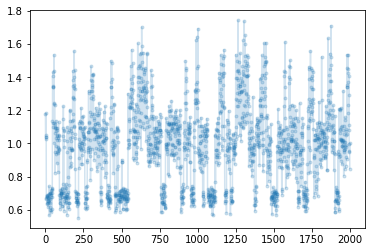

In [9]:
colors = array(['C0','C1'])
t = arange(2000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[1])
plot(t,X[i,:],'.-',alpha=0.2)
plot(t[Y[i,:]==0],X[i,Y[i,:]==0],'.',alpha=0.2)

In [10]:
max(Y[i,:])

1

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [11]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],1))

In [12]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    X_input = Input(shape = input_shape)
    
    # Layers

    Xt = Conv1D(20,11,strides = 3)(X_input)
    Xt = BatchNormalization()(Xt)
    Xt = Activation("relu")(Xt)
    Xa = Xt
    
    Xt = Conv1D(20,24,strides = 5)(X_input)
    Xt = BatchNormalization()(Xt)
    Xt = Activation("relu")(Xt)
    Xb = Xt
    
    X = Concatenate(axis=1)([Xa, Xb])
    X = Dense(200, activation='relu')(X)
    X = Dense(1,activation="softmax")(X)
    
    Xt = Conv1D(10,5,strides = 2)(X)
    Xt = BatchNormalization()(Xt)
    Xt = Activation("relu")(Xt)
    Xa = Xt
    
    Xt = Conv1D(10,7,strides = 3)(X)
    Xt = BatchNormalization()(Xt)
    Xt = Activation("relu")(Xt)
    Xb = Xt
    
    X = Concatenate(axis=1)([Xa, Xb])
    X = Dense(5, activation='relu')(X)
    X = Reshape((200,2))(X)
    
    X = Dense(1,activation="softmax")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [292]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    
    X_input = Input(shape = input_shape)
    
    # Layers

    X = X_input

    Xa = Conv1D(20,10,strides = 4,padding="same")(X)
    Xa = BatchNormalization()(Xa)
    Xa = Activation("relu")(Xa)

    Xa = Conv1D(40,5,strides = 2,padding="same")(Xa)
    Xa = BatchNormalization()(Xa)
    Xa = Activation("relu")(Xa)

    X = Dense(10,activation="relu")(Xa)
    X = Dense(16,activation="relu")(X)
    #Xb = Dense(10,activation="softmax")(X)
    #X = Concatenate()([Xa,Xb])
    X = Reshape((2000,2))(X)

    X = Dense(1,activation="sigmoid")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [293]:
model = model(input_shape = (nframes,1))

In [294]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 2000, 1)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 500, 20)           220       
_________________________________________________________________
batch_normalization_75 (Batc (None, 500, 20)           80        
_________________________________________________________________
activation_75 (Activation)   (None, 500, 20)           0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 250, 40)           4040      
_________________________________________________________________
batch_normalization_76 (Batc (None, 250, 40)           160       
_________________________________________________________________
activation_76 (Activation)   (None, 250, 40)           0         
__________

### Fit the model!

In [295]:
from keras.optimizers import SGD

In [296]:
opt = Adam(lr=0.005, beta_1=0.90, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [297]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [298]:
history3 = model.fit(X, Y, batch_size = 500, epochs = 40)

Epoch 1/40
20000/20000 [==============================] - 23s 1ms/step - loss: 0.4630 - acc: 0.8275
Epoch 2/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2166 - acc: 0.8869
Epoch 3/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1465 - acc: 0.9213
Epoch 4/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1062 - acc: 0.9596
Epoch 5/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0999 - acc: 0.9620
Epoch 6/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0974 - acc: 0.9629
Epoch 7/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0975 - acc: 0.9628
Epoch 8/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0983 - acc: 0.9625
Epoch 9/40
20000/20000 [==============================] - 23s 1ms/step - loss: 0.0970 - acc: 0.9631
Epoch 10/40
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0938 - acc: 0.9643

In [299]:
Wsave_trained1 = model.get_weights()
#Wsave_trained2 = model.get_weights()
#Wsave_trained3 = model.get_weights()

dict_keys(['loss', 'acc'])


Text(0.5,0,'epoch')

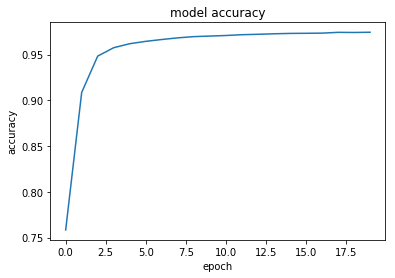

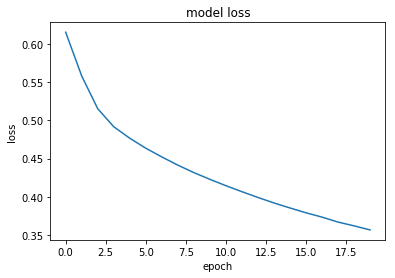

In [300]:
figure()
print(history2.history.keys())
#plot(history.history['acc'])
plot(history2.history['acc'])
title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
plot(history2.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


In [301]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

500/500 [==============================] - 1s 2ms/step
Dev set accuracy =  0.9585209927558899


In [164]:
%matplotlib notebook

<IPython.core.display.Javascript object>


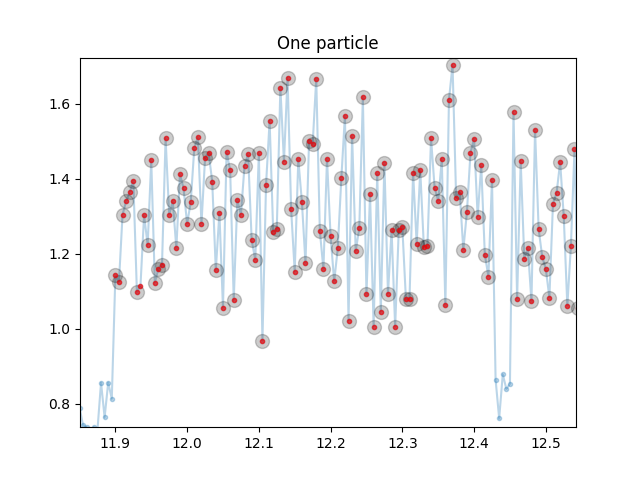

8.14 8.025 0.115 0.02


In [165]:
figure()
i = 4031
a = load("syndat/d"+str(i).zfill(4)+".npy");
b = load("syndat/r"+str(i).zfill(4)+".npy");
n0 = randint(0,12000-nframes)
#n0 = 5000
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)
b = b[start:end]

if pars[i][-1]>1:
    title("Cluster with "+str(int(pars[i][-1]))+" particles")
else:
    title("One particle")
plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'ko',alpha=0.2,ms=10)
plot(t[start:end][b==0],a[start:end][b==0],'r.',alpha=0.6)

total0 = sum(b==0)/200
totalac = sum((b==0)*(y<=0.5))/200
totalfn =sum((b==0)*(y>=0.5))/200
totalfp =sum((b==1)*(y<=0.5))/200
print(total0,totalac,totalfn,totalfp)

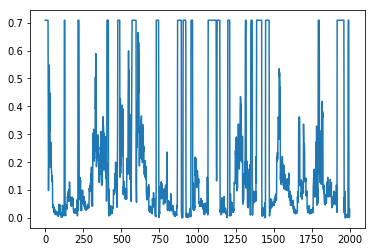

In [166]:
%matplotlib inline
xt = reshape(a[start:end],(1,2000,1))
plot(model.predict(xt)[0,:,0])

In [104]:
historybkp = history2

In [302]:
model.save("network20180417c.h5")

In [21]:
h5py

<module 'h5py' from '/home/pablo/environments/deeplearning/lib/python3.6/site-packages/h5py/__init__.py'>

## Real Data
### Control first

What is it going to happeeeennn!!!!!!!?!?!??!?!?!?!?!?!?



In [168]:
basedir = "realcontrol/"
filesA = os.listdir(basedir)
files = []
for file in filesA:
    if file[-4:]==".npy":
        files.append(basedir+file)
print(len(files))


33


In [169]:
files

['realcontrol/_control_no voltage_2__13.npy',
 'realcontrol/_control_no voltage__10.npy',
 'realcontrol/_control_no voltage_2__09.npy',
 'realcontrol/_control_no voltage_2__12.npy',
 'realcontrol/_control_no voltage_2__18.npy',
 'realcontrol/_control_no voltage_2__07.npy',
 'realcontrol/_control_no voltage_2__06.npy',
 'realcontrol/_control_no voltage__09.npy',
 'realcontrol/_control_no voltage__03.npy',
 'realcontrol/_control_no voltage_2__15.npy',
 'realcontrol/_control_no voltage_2__04.npy',
 'realcontrol/_control_no voltage__05.npy',
 'realcontrol/_control_no voltage_2__19.npy',
 'realcontrol/_control_no voltage__11.npy',
 'realcontrol/_control_no voltage_2__11.npy',
 'realcontrol/_control_no voltage_2__05.npy',
 'realcontrol/_control_no voltage__04.npy',
 'realcontrol/_control_no voltage__06.npy',
 'realcontrol/_control_no voltage__13.npy',
 'realcontrol/_control_no voltage_2__17.npy',
 'realcontrol/_control_no voltage_2__03.npy',
 'realcontrol/_control_no voltage__02.npy',
 'real

In [219]:
n0 = randint(len(files))
#n0 = -5
a = load(files[n0]);
print(n0+1)

15


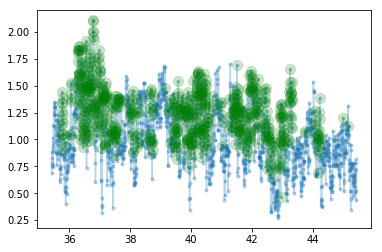

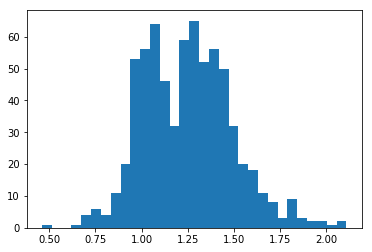

In [225]:
figure("Control")

n0 = randint(0,12000-nframes)
#n0 = 12*200
t = arange(12000)*5e-3
start, end = (n0,n0+nframes)

plot(t[start:end],a[start:end],'.-',alpha=0.3)
xt = reshape(a[start:end],(1,nframes,1))
y = model.predict(xt)[0,:,0]
plot(t[start:end][y<=0.5],a[start:end][y<=0.5],'go',alpha=0.2,ms=10)
figure()
hist(a[start:end][y<=0.5],bins=31);